In [1]:

# import kagglehub
# import os

# os.environ['KAGGLEHUB_CACHE'] = r'C:\Users\yunju\study\bk21\data'

# # LEMOCAP
# # https://www.kaggle.com/datasets/dejolilandry/iemocapfullrelease
# path = kagglehub.dataset_download("dejolilandry/iemocapfullrelease")

# # CREMA-D
# # https://www.kaggle.com/datasets/ejlok1/cremad/data
# # path = kagglehub.dataset_download("ejlok1/cremad")

# print("Path to dataset files:", path)


In [2]:
import numpy as np
import pandas as pd

In [3]:
audios = pd.DataFrame(data=[], columns=['Dataset', 'Path', "File", "Emotion", "SpeakerID"])
audios

,Dataset,Path,File,Emotion,SpeakerID


In [4]:
CREMAD = f"C:/Users/yunju/study/bk21/data/CREMA-D/"
IEMOCAP = f"C:/Users/yunju/study/bk21/data/IEMOCAP/"

In [5]:
from joblib import delayed, Parallel
import os
import time

# Adding CREMA-D files to the dataframe
emotion_map = {"DIS": "Disgust", "SAD": "Sad", "HAP": "Happy", 
              "NEU": "Neutral", "FEA": "Fearful", "ANG": "Angry"}

def crema_process(file:str):
    parts      = file.split("_")
    actor_id   = int(parts[0])           # 1001 … 1091
    emotion    = emotion_map[parts[2]]
    return {
        "Dataset"  : "CREMA-D",
        "Path"     : os.path.join(CREMAD, file),
        "File"     : file.rsplit(".",1)[0],
        "Emotion"  : emotion,
        "SpeakerID": actor_id           # 배우 ID 그대로!
    }

crema_rows = Parallel(n_jobs=-1,verbose=5)(delayed(crema_process)(f)
                  for f in os.listdir(CREMAD) if f.endswith(".wav"))
audios = pd.concat([audios, pd.DataFrame(crema_rows)], ignore_index=True)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6516 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 7442 out of 7442 | elapsed:    0.6s finished


In [6]:
from tqdm import tqdm

# Adding IEMOCAP
accepted_emotions = ["Happiness", "Anger", "Calm", "Neutral", "Sadness", "Disgust", "Surprise", "Fear", "Frustration", "Excited"]
emo_map = {'anger': "Angry", 'disgust': "Disgust", 'fear': "Fearful", 'happiness': "Happy", "frustration": "Frustration",
               'neutral state': "Neutral", 'sadness': "Sad", 'surprise': "Surprised", 'excited': "Excited"}

# 세션‑성별 태그 → 고유 int ID
sess_tags = [f"Ses0{n}{g}" for n in range(1,6) for g in ("F","M")]
tag2id    = {tag:i for i,tag in enumerate(sess_tags)}


def iemocap_session(root:str, sess_no:int)->pd.DataFrame:
    lbl_dir = os.path.join(root, f"Session{sess_no}", "dialog","EmoEvaluation","Categorical")
    wav_dir = os.path.join(root, f"Session{sess_no}", "sentences","wav")
    rows=[]
    for txt in tqdm(os.listdir(lbl_dir), desc=f"Sess{sess_no}"):
        if not txt.endswith("_cat.txt"): continue
        with open(os.path.join(lbl_dir,txt)) as f:
            for line in f:
                wavfile,*emos = line.split(" :")
                sess_tag = wavfile.split("_")[0]       # e.g. Ses02F
                wav_path = os.path.join(wav_dir, "_".join(wavfile.split("_")[:-1]), wavfile+".wav")
                if not os.path.exists(wav_path): continue
                try:
                    emo_raw = next(e for e in emos if any(ae in e for ae in accepted_emotions))
                except StopIteration:
                    continue
                emo_key = emo_raw.split(";")[0].strip().lower()
                if emo_key not in emo_map: continue
                rows.append({
                    "Dataset"  : "IEMOCAP",
                    "Path"     : wav_path,
                    "File"     : wavfile,
                    "Emotion"  : emo_map[emo_key],
                    "SpeakerID": tag2id[sess_tag]      # 0~9 고유 ID
                })
    return pd.DataFrame(rows)

iem_rows = Parallel(n_jobs=-1,verbose=5)(delayed(iemocap_session)(IEMOCAP,s) for s in range(1,6))
audios   = pd.concat([audios, *iem_rows], ignore_index=True)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [7]:
audios

,Dataset,Path,File,Emotion,SpeakerID
0,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_ANG_XX,Angry,1001
1,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_DIS_XX,Disgust,1001
2,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_FEA_XX,Fearful,1001
3,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_HAP_XX,Happy,1001
4,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_NEU_XX,Neutral,1001
...,...,...,...,...,...
36900,IEMOCAP,C:/Users/yunju/study/bk21/data/IEMOCAP/Session...,Ses05M_script03_2_M041,Angry,9
36901,IEMOCAP,C:/Users/yunju/study/bk21/data/IEMOCAP/Session...,Ses05M_script03_2_M042,Angry,9
36902,IEMOCAP,C:/Users/yunju/study/bk21/data/IEMOCAP/Session...,Ses05M_script03_2_M043,Angry,9
36903,IEMOCAP,C:/Users/yunju/study/bk21/data/IEMOCAP/Session...,Ses05M_script03_2_M044,Angry,9


(array(['CREMA-D', 'IEMOCAP'], dtype=object), <Axes: ylabel='count'>)

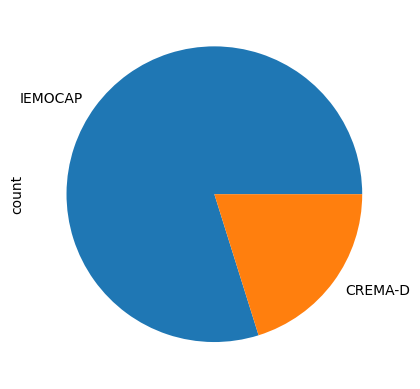

In [8]:
# Dataset distribution
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

%matplotlib inline

audios.Dataset.unique(), audios.Dataset.value_counts().plot.pie()

(array(['Angry', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad',
        'Frustration', 'Surprised', 'Excited'], dtype=object),
 <Axes: xlabel='Emotion'>)

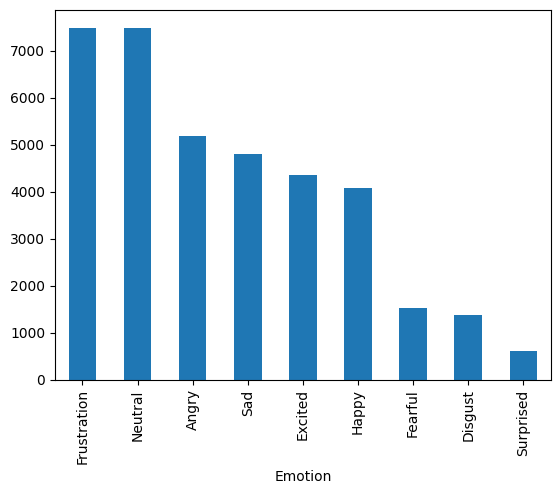

In [9]:
# Emotion distribution
audios.Emotion.unique(), audios.Emotion.value_counts().plot.bar()

In [10]:
import pyloudnorm as pyln
import librosa

SAMPLE_RATE = 16000
meter = pyln.Meter(SAMPLE_RATE)

def estimate_snr(y):
    signal_power = np.mean(y**2)
    noise_power = np.var(y - np.mean(y))
    return 10 * np.log10(signal_power / (noise_power + 1e-12))

def process_file(idx, row, meter):
    audio_path = row['Path']
    try:
        y, sr_actual = librosa.load(audio_path)
        duration = librosa.get_duration(y=y, sr=sr_actual)
        loudness = meter.integrated_loudness(y)
        signal_to_noise = estimate_snr(y)
        silence_pct = np.sum(np.abs(y) < 0.001) / len(y)
        
        return {
            "ID": idx,
            'path': audio_path,
            "dataset": row['Dataset'],
            'duration': duration,
            'sample_rate': sr_actual,
            'loudness': loudness,
            'rms': np.sqrt(np.mean(y**2)),
            'peak': np.max(np.abs(y)),
            "signal_to_noise": signal_to_noise,
            "silence_pct": silence_pct,
            'emotion': row['Emotion']
        }
    except Exception as e:
        print(f"⚠️ Error processing {audio_path}: {e}")
        return idx


def get_info(df, sample_size=5, sr=SAMPLE_RATE, meter=meter, sup_dir="/kaggle/working"):
    """
    Verify audio files exist and can be used and check their properties
    """
    print("🔍 Verifying audio files...")
        
    # Check all files with progress bar
    results = Parallel(n_jobs=-1)(
        delayed(process_file)(idx, row, meter) for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking audio files")
    )

    audio_info = [r for r in results if type(r) == dict]
    invalid_files = [r for r in results if type(r) != dict]
    
    print(f"✅ Valid files: {len(audio_info)}")
    print(f"❌ Invalid files: {len(invalid_files)}")
    
    if len(audio_info) == 0:
        print("⚠️  No valid audio files found.")
        return
        
    # Plot sample rate distribution
    if len(audio_info) > 1:
        sr_df = pd.DataFrame(audio_info)
        print(f"Length of DataFrame: {len(sr_df)}")        
        
        plt.figure(figsize=(10, 10))

        # Sample Rate Distribution
        plt.subplot(3, 3, 1)
        sr_df['sample_rate'].hist(bins=20, alpha=0.7, color='lightcoral')
        plt.title('Sample Rate Distribution')
        plt.xlabel('Sample Rate (Hz)')
        plt.ylabel('Count')

        # Duration Distribution
        plt.subplot(3, 3, 2)
        sr_df['duration'].hist(bins=20, alpha=0.7, color='lightgreen')
        plt.title('Audio Duration Distribution')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Count')

        try:
            # pyln Loudness Distribution
            plt.subplot(3, 3, 3)
            sr_df['loudness'].hist(bins=20, alpha=0.7, color='red')
            plt.title('LUFS Loudness Distribution')
            plt.xlabel('Loudness (dB)')
            plt.ylabel('Count')
        except Exception as e:
            print("Exception occured while displaying the loudness Distribution chart:", str(e))

        # RMS Value Distribution
        plt.subplot(3, 3, 4)
        sr_df['rms'].hist(bins=20, alpha=0.7, color='lightpink')
        plt.title('RMS Perceptual Energy Distribution')
        plt.xlabel('Energy Value')
        plt.ylabel('Count')

        # Peak Value Distribution
        plt.subplot(3, 3, 5)
        sr_df['peak'].hist(bins=20, alpha=0.7, color='darkgreen')
        plt.title('Peak Distribution')
        plt.xlabel('Energy Value')
        plt.ylabel('Count')

        # Silence Distribution
        plt.subplot(3, 3, 6)
        sr_df['silence_pct'].hist(bins=20, alpha=0.7, color='purple')
        plt.title('Silence Distribution')
        plt.xlabel('Silence %')
        plt.ylabel('Count')
        
        # Signal-to-Noise Distribution
        try:
            plt.subplot(3, 3, 7)
            sr_df['signal_to_noise'].hist(bins=20, alpha=0.7, color='yellow')
            plt.title('Signal-to-Noise Distribution')
            plt.xlabel('Ratio')
            plt.ylabel('Count')
        except Exception as e:
            print("Exception occured while displaying the Signal-to-Noise Distribution chart:", str(e))

        
        plt.tight_layout()
        plt.show()

    return sr_df, invalid_files

🔍 Verifying audio files...


Checking audio files: 100%|██████████| 36905/36905 [00:29<00:00, 1259.59it/s]


✅ Valid files: 36905
❌ Invalid files: 0
Length of DataFrame: 36905
Exception occured while displaying the loudness Distribution chart: supplied range of [-inf, -4.975972372486846] is not finite
Exception occured while displaying the Signal-to-Noise Distribution chart: supplied range of [-inf, 0.00420753750950098] is not finite


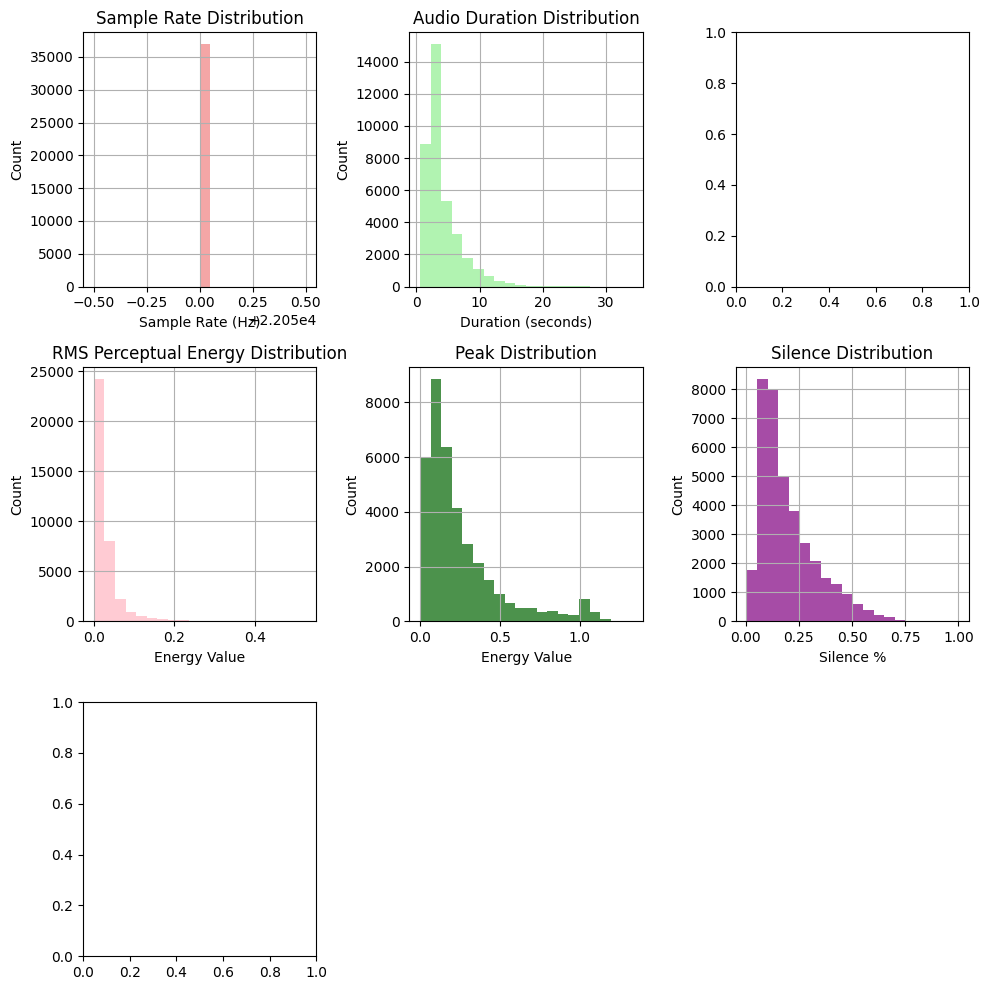

In [11]:
# Verify audio files
sr_df, invalid_files = get_info(audios)

In [12]:
# Display invalid files
for idx in invalid_files:
    row = audios.iloc[idx]
    print(f"File: {row.Path}, Emotion: {row.Emotion}")
    ipd.display(ipd.Audio(filename=row.Path))

In [13]:
# Let's go ahead and remove the invalid files
audios.drop(invalid_files, axis=0, inplace=True)
audios

,Dataset,Path,File,Emotion,SpeakerID
0,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_ANG_XX,Angry,1001
1,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_DIS_XX,Disgust,1001
2,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_FEA_XX,Fearful,1001
3,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_HAP_XX,Happy,1001
4,CREMA-D,C:/Users/yunju/study/bk21/data/CREMA-D/1001_DF...,1001_DFA_NEU_XX,Neutral,1001
...,...,...,...,...,...
36900,IEMOCAP,C:/Users/yunju/study/bk21/data/IEMOCAP/Session...,Ses05M_script03_2_M041,Angry,9
36901,IEMOCAP,C:/Users/yunju/study/bk21/data/IEMOCAP/Session...,Ses05M_script03_2_M042,Angry,9
36902,IEMOCAP,C:/Users/yunju/study/bk21/data/IEMOCAP/Session...,Ses05M_script03_2_M043,Angry,9
36903,IEMOCAP,C:/Users/yunju/study/bk21/data/IEMOCAP/Session...,Ses05M_script03_2_M044,Angry,9


In [14]:
loudness = sr_df.loudness
loudness.describe(), loudness.argmax(), loudness.argmin()

c:\Users\yunju\AppData\Local\anaconda3\envs\llm2\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


(count    3.690500e+04
 mean             -inf
 std               NaN
 min              -inf
 25%     -3.874211e+01
 50%     -3.346018e+01
 75%     -2.822765e+01
 max     -4.975972e+00
 Name: loudness, dtype: float64,
 np.int64(12534),
 np.int64(6187))

In [15]:
# Sorting the loudness values in ascending order
loudness.sort_values(ascending=True).head(10)

6187          -inf
22170   -63.619642
22116   -63.619642
22222   -63.619642
22114   -62.695154
22220   -62.695154
22168   -62.695154
22171   -62.358503
22223   -62.358503
22117   -62.358503
Name: loudness, dtype: float64

In [16]:
import IPython.display as ipd

# Showing all files that have -inf real loudness
inf_loudness = sr_df[sr_df.loudness == -np.inf]

for _, row in inf_loudness.iterrows():
    print("ID:", row.ID)
    ipd.display(ipd.Audio(filename=row.path, rate=row.sample_rate))

ID: 6187


🔍 Verifying audio files...


Checking audio files: 100%|██████████| 36904/36904 [00:25<00:00, 1457.24it/s]


✅ Valid files: 36904
❌ Invalid files: 0
Length of DataFrame: 36904


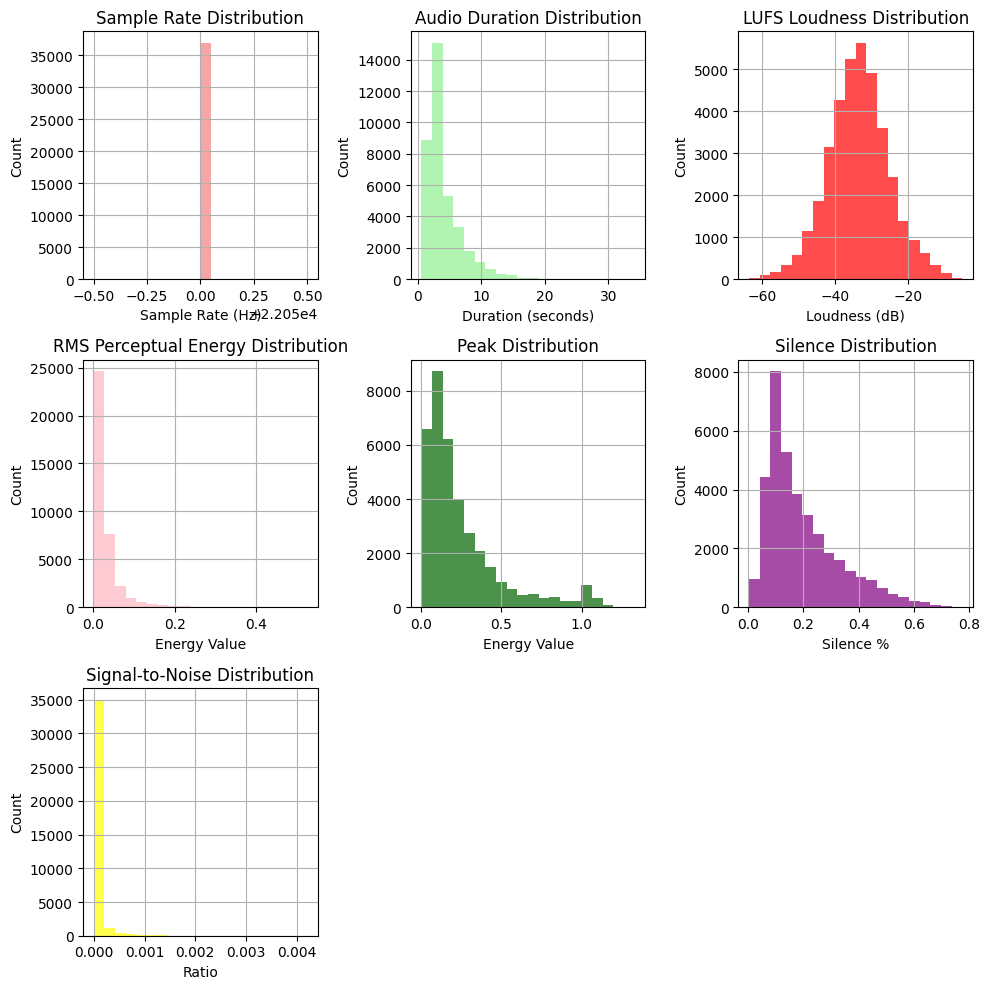

In [17]:
audios.drop(inf_loudness.ID, axis=0, inplace=True)

# Re-verify the files
sr_df, invalid_files = get_info(audios)

In [18]:
# Getting the stats of SNR ratio, Sample Rate, loudness, peak and RMS energy for all the files
sr_df[['signal_to_noise', 'sample_rate', 'loudness', 'peak', 'rms']].describe().T

,count,mean,std,min,25%,50%,75%,max
signal_to_noise,36904.0,0.000051,0.000173,-0.000001,0.000003,0.000009,0.000032,0.004208
sample_rate,36904.0,22050.000000,0.000000,22050.000000,22050.000000,22050.000000,22050.000000,22050.000000
loudness,36904.0,-33.396522,8.351909,-63.619642,-38.741498,-33.459948,-28.227626,-4.975972
peak,36904.0,0.251538,0.242748,0.005024,0.089076,0.167709,0.318918,1.328815
rms,36904.0,0.029600,0.036816,0.000838,0.010288,0.018745,0.033873,0.526532


In [19]:
# From the RMS and peak value statistics, it seems like there are some almost silent files as well.
# Let's display the 30 lowest RMS value files and see if they should be in the dataset or not

lowest_rms = sr_df.sort_values(by='rms', ascending=True)

for idx, row in lowest_rms.head(10).iterrows():
    print(f"Dataset: {row.dataset}; Emotion: {row.emotion}; loudness: {row.loudness:.6f}; peak: {row.peak:.6f}; rms: {row.rms:.6f}")
    ipd.display(ipd.Audio(filename=row.path, rate=row.sample_rate, autoplay=True))
    time.sleep(row.duration+1)
    ipd.clear_output()

In [20]:
TARGET_RMS = 0.05

def normalize_rms(path):
    wave, sr = librosa.load(path)
    
    # Mono conversion if necessary
    if wave.ndim > 1: wave = wave.mean(dim=0, keepdim=True)
    
    rms = np.sqrt(np.mean(wave ** 2))               # Current RMS
    gain = TARGET_RMS / (rms + 1e-8)                # Compute Gain
    norm_wave = wave * gain                         # Apply Gain
    
    new_loudness = meter.integrated_loudness(norm_wave)
    new_peak = np.max(np.abs(norm_wave))
    
    return norm_wave, sr, new_loudness, new_peak

In [21]:
# First the lowest RMS files
for idx, row in lowest_rms.head(10).iterrows():
    ipd.clear_output()
    
    wave, sr, loudness, peak = normalize_rms(row.path)
    
    print(f"Dataset: {row.dataset}; Emotion: {row.emotion}")
    print(f"Old loudness: {row.loudness}; New loudness: {loudness}")
    print(f"Old peak: {row.peak}; New peak: {peak}")

    ipd.display(ipd.Audio(wave, rate=sr, autoplay=True))
    time.sleep(row.duration+1)

# Then the ones that had a relatively lower RMS
for idx, row in lowest_rms.head(50).tail(10).iterrows():
    ipd.clear_output()
    
    wave, sr, loudness, peak = normalize_rms(row.path)
    
    print(f"Dataset: {row.dataset}; Emotion: {row.emotion}")
    print(f"Old loudness: {row.loudness}; New loudness: {loudness}")
    print(f"Old peak: {row.peak}; New peak: {peak}")
    ipd.display(ipd.Audio(wave, rate=sr, autoplay=True))
    # time.sleep(row.duration+1)

Dataset: IEMOCAP; Emotion: Neutral
Old loudness: -60.51755976686437; New loudness: -28.606101132902932
Old peak: 0.009395883418619633; New peak: 0.3702631890773773


In [22]:
lowest_rms_above_60db = lowest_rms[lowest_rms.loudness > -60]

# First the lowest RMS files with loudness above -60dB
for idx, row in lowest_rms_above_60db.head(10).iterrows():
    ipd.clear_output()
    
    wave, sr, loudness, peak = normalize_rms(row.path)
    
    print(f"Dataset: {row.dataset}; Emotion: {row.emotion}")
    print(f"Old loudness: {row.loudness}; New loudness: {loudness}")
    print(f"Old peak: {row.peak}; New peak: {peak}")

    ipd.display(ipd.Audio(filename=row.path, rate=sr, autoplay=True))
    time.sleep(row.duration+1)
    ipd.display(ipd.Audio(wave, rate=sr, autoplay=True))
    time.sleep(row.duration+1)

Dataset: IEMOCAP; Emotion: Sad
Old loudness: -59.52151924043947; New loudness: -26.824510283842294
Old peak: 0.014194143004715443; New peak: 0.6122934818267822


KeyboardInterrupt: 

In [23]:
# Checking the number of files below the threshold, and the datasets and emotions they belong to
loudness_below_60dB = lowest_rms[lowest_rms.loudness < -60]

print("Number of files we're removing: ", loudness_below_60dB.shape[0])
print("\nDatasets from which we're removing files: ", dict(loudness_below_60dB.dataset.value_counts()))
print("\nEmotions from which we're removing files: ", dict(loudness_below_60dB.emotion.value_counts()))

Number of files we're removing:  26

Datasets from which we're removing files:  {'IEMOCAP': np.int64(26)}

Emotions from which we're removing files:  {'Sad': np.int64(19), 'Neutral': np.int64(6), 'Frustration': np.int64(1)}


🔍 Verifying audio files...


Checking audio files: 100%|██████████| 36878/36878 [00:24<00:00, 1483.25it/s]


✅ Valid files: 36878
❌ Invalid files: 0
Length of DataFrame: 36878


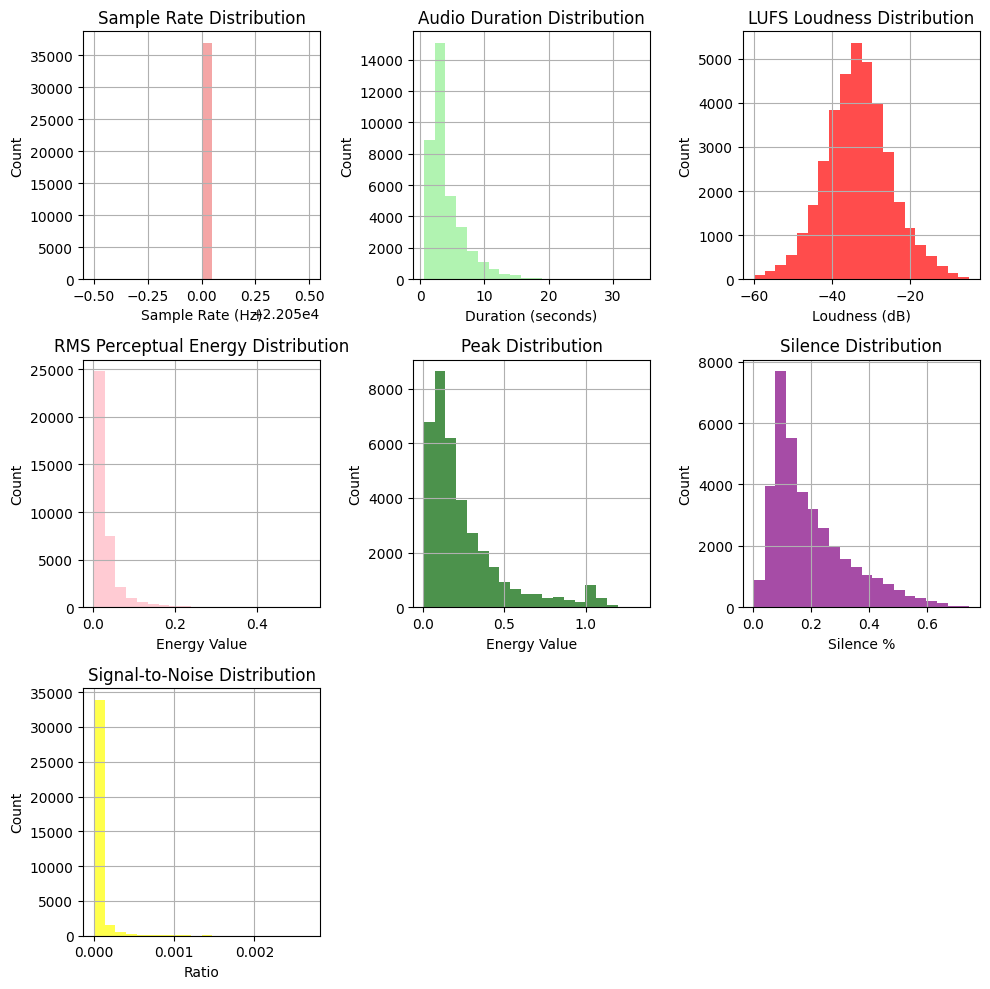

In [24]:
audios.drop(list(loudness_below_60dB.ID), axis=0, inplace=True)

# Again re-verify the files
sr_df, invalid_files = get_info(audios)

In [25]:
sr_df.loudness.min(), sr_df.rms.min(), sr_df.peak.min()


(np.float64(-59.98130335740902),
 np.float32(0.0011386281),
 np.float32(0.0067340992))

In [26]:
# Getting the duration stats
durations = sr_df.duration.round()
durations.value_counts().sort_index()

duration
1.0      2027
2.0     10153
3.0      9465
4.0      4570
5.0      2746
6.0      2174
7.0      1689
8.0      1130
9.0       773
10.0      654
11.0      430
12.0      331
13.0      203
14.0      154
15.0      134
16.0       65
17.0       51
18.0       44
19.0       18
20.0       12
21.0        9
22.0        5
23.0        6
24.0       15
25.0        2
27.0        6
29.0        6
32.0        3
34.0        3
Name: count, dtype: int64

In [27]:
durations.round().describe()


count    36878.000000
mean         4.075899
std          2.875797
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         34.000000
Name: duration, dtype: float64

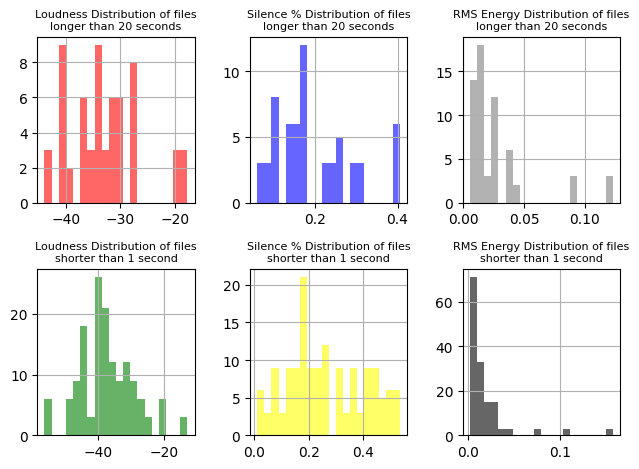

In [28]:
# Plotting the Loudness distribution, RMS Distribution and Silence % distribution of the files with length 
# longer than 20 seconds, shorter than 1 second (unrounded)

plt.subplot(2, 3, 1)
sr_df[(sr_df.duration > 20.0)]['loudness'].hist(bins=20, alpha=0.6, color='red')
plt.title("Loudness Distribution of files\nlonger than 20 seconds", fontsize=8)

plt.subplot(2, 3, 2)
sr_df[(sr_df.duration > 20.0)]['silence_pct'].hist(bins=20, alpha=0.6, color='blue')
plt.title("Silence % Distribution of files\nlonger than 20 seconds", fontsize=8)

plt.subplot(2, 3, 3)
sr_df[(sr_df.duration > 20.0)]['rms'].hist(bins=20, alpha=0.6, color='gray')
plt.title("RMS Energy Distribution of files\nlonger than 20 seconds", fontsize=8)

plt.subplot(2, 3, 4)
sr_df[(sr_df.duration < 1.0)]['loudness'].hist(bins=20, alpha=0.6, color='green')
plt.title("Loudness Distribution of files\nshorter than 1 second", fontsize=8)

plt.subplot(2, 3, 5)
sr_df[(sr_df.duration < 1.0)]['silence_pct'].hist(bins=20, alpha=0.6, color='yellow')
plt.title("Silence % Distribution of files\nshorter than 1 second", fontsize=8)

plt.subplot(2, 3, 6)
sr_df[(sr_df.duration < 1.0)]['rms'].hist(bins=20, alpha=0.6, color='black')
plt.title("RMS Energy Distribution of files\nshorter than 1 second", fontsize=8)

plt.tight_layout()
plt.show()

In [29]:
# Getting the duration stats by the Dataset
ds_df = sr_df.copy().groupby('dataset')
ds_df["duration"].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
CREMA-D,7441.0,2.542907,0.506014,1.267982,2.202222,2.502540,2.836190,5.005034
IEMOCAP,29437.0,4.466902,3.067197,0.584943,2.333333,3.529977,5.718776,34.138776


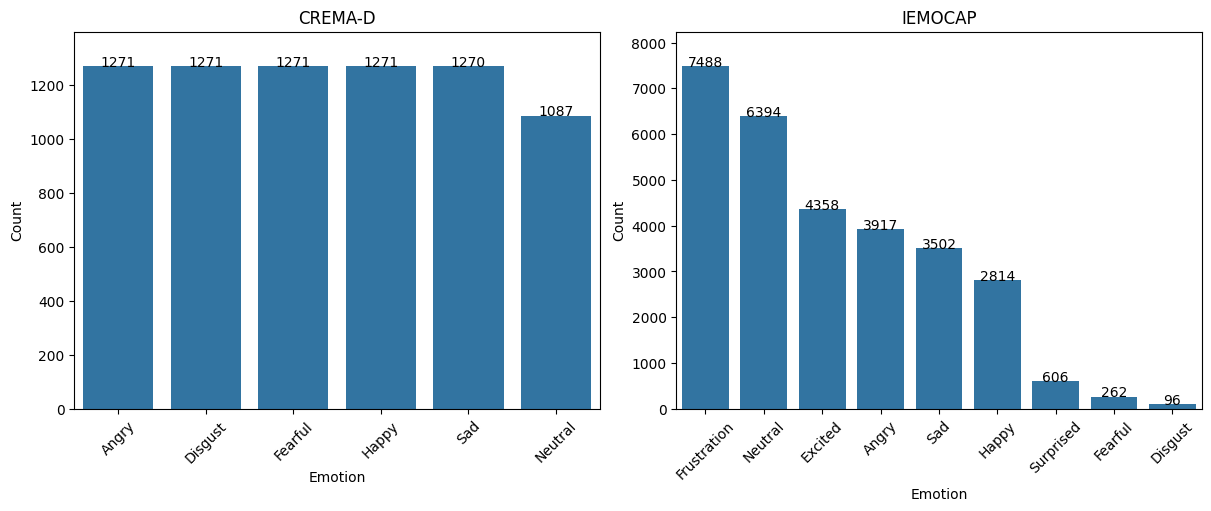

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset 개수
num_datasets = len(sr_df.dataset.unique())

# 1행 N열로 배치
fig, axes = plt.subplots(nrows=1, ncols=num_datasets, figsize=(6 * num_datasets, 5), constrained_layout=True)

# axes가 1개인 경우도 리스트로 처리
if num_datasets == 1:
    axes = [axes]

# 각 그래프 그리기
for ax, dataset in zip(axes, sr_df.dataset.unique()):
    subset = sr_df[sr_df['dataset'] == dataset]
    sns.countplot(data=subset, x='emotion', ax=ax, order=subset['emotion'].value_counts().index)
    ax.set_title(f"{dataset}")
    ax.set_xlabel("Emotion")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, subset['emotion'].value_counts().max() * 1.1)

    # 숫자 표시
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.05, int(height), ha="center", fontsize=10)

plt.show()


In [31]:
# Get the overall stats of all the features by the datasets


ds_df[['duration', 'loudness', 'rms', 'silence_pct', 'signal_to_noise']].describe(percentiles=[]).T

dataset                    CREMA-D       IEMOCAP
duration        count  7441.000000  29437.000000
                mean      2.542907      4.466902
                std       0.506014      3.067197
                min       1.267982      0.584943
                50%       2.502540      3.529977
                max       5.005034     34.138776
loudness        count  7441.000000  29437.000000
                mean    -30.690217    -34.055414
                std       8.178741      8.218055
                min     -49.625677    -59.981303
                50%     -31.433434    -33.852034
                max      -8.798293     -4.975972
rms             count  7441.000000  29437.000000
                mean      0.039100      0.027224
                std       0.042364      0.034877
                min       0.003735      0.001139
                50%       0.022622      0.017776
                max       0.303491      0.526532
silence_pct     count  7441.000000  29437.000000
                mean      0.100662      0.222531
                std       0.025976      0.138902
                min       0.030044      0.002957
                50%       0.098852      0.191899
                max       0.359729      0.746147
signal_to_noise count  7441.000000  29437.000000
                mean      0.000018      0.000057
                std       0.000036      0.000167
                min      -0.000001     -0.000001
                50%       0.000005      0.000010
                max       0.000621      0.002685

In [32]:
from torch.utils.data import Dataset, DataLoader  # 필요 모듈 임포트
import torch, torchaudio, torch.nn.functional as F

TARGET_SR  = 22050
TARGET_RMS = 0.03
MAX_PEAK   = 0.99
DURATION   = 5.0
NUM_SAMPLES= int(TARGET_SR*DURATION)
MIN_SAMPLES= NUM_SAMPLES//2
OUT_ROOT   = r"C:/Users/yunju/study/bk21/data/working"
os.makedirs(OUT_ROOT, exist_ok=True)


def normalize_rms(w:torch.Tensor):
    rms  = torch.sqrt(torch.mean(w**2))
    gain = TARGET_RMS/(rms+1e-8)
    w    = w*gain
    pk   = torch.max(torch.abs(w))
    if pk>MAX_PEAK: w*=MAX_PEAK/(pk+1e-8)
    return w


def chunk_and_save(idx,row):
    try:
        wave,sr = torchaudio.load(row.Path)
    except: return []
    if sr!=TARGET_SR:
        wave = torchaudio.transforms.Resample(sr,TARGET_SR)(wave)
    if wave.shape[0]>1:
        wave = wave.mean(0,keepdim=True)
    wave = normalize_rms(wave)

    out=[]; total=wave.shape[1]
    for c in range((total+NUM_SAMPLES-1)//NUM_SAMPLES):
        st,ed = c*NUM_SAMPLES,(c+1)*NUM_SAMPLES
        chk   = wave[:,st:ed]
        if chk.shape[1]<MIN_SAMPLES and c>0: break
        if chk.shape[1]<NUM_SAMPLES:
            chk = F.pad(chk,(0,NUM_SAMPLES-chk.shape[1]))
        suffix = f"_{c}" if c else ""
        save_d = os.path.join(OUT_ROOT,row.Dataset,row.Emotion)
        os.makedirs(save_d, exist_ok=True)
        torch.save(chk, os.path.join(save_d, f"{row.File}{suffix}.pt"))
        out.append({
            "Dataset":row.Dataset,
            "Emotion":row.Emotion,
            "File":   row.File+suffix,
            "SpeakerID":row.SpeakerID
        })
    return out

flat = Parallel(n_jobs=-1,verbose=5)(delayed(chunk_and_save)(i,r) for i,r in audios.iterrows())
chunks_df = pd.DataFrame([itm for lst in flat for itm in lst])
print("✅ Preprocessing complete!", len(chunks_df), "chunks saved")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
c:\Users\yunju\AppData\Local\anaconda3\envs\llm2\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2252 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 4740 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 7908 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 11652 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 15972 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 20868 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 26340 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 32388 tasks      | elapsed:   58.6s


✅ Preprocessing complete! 41853 chunks saved


[Parallel(n_jobs=-1)]: Done 36852 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 36878 out of 36878 | elapsed:  1.1min finished


In [33]:
chunks_df.to_csv(
    "saved_files_with_speaker.csv",
    index=False,
)

In [34]:
chunks_df

,Dataset,Emotion,File,SpeakerID
0,CREMA-D,Angry,1001_DFA_ANG_XX,1001
1,CREMA-D,Disgust,1001_DFA_DIS_XX,1001
2,CREMA-D,Fearful,1001_DFA_FEA_XX,1001
3,CREMA-D,Happy,1001_DFA_HAP_XX,1001
4,CREMA-D,Neutral,1001_DFA_NEU_XX,1001
...,...,...,...,...
41848,IEMOCAP,Angry,Ses05M_script03_2_M041_1,9
41849,IEMOCAP,Angry,Ses05M_script03_2_M042,9
41850,IEMOCAP,Angry,Ses05M_script03_2_M043,9
41851,IEMOCAP,Angry,Ses05M_script03_2_M044,9
